Let's discuss a simplified version of the QARMAv2 cipher, specifically the QARMAv2-64-128 version.

## Round functions

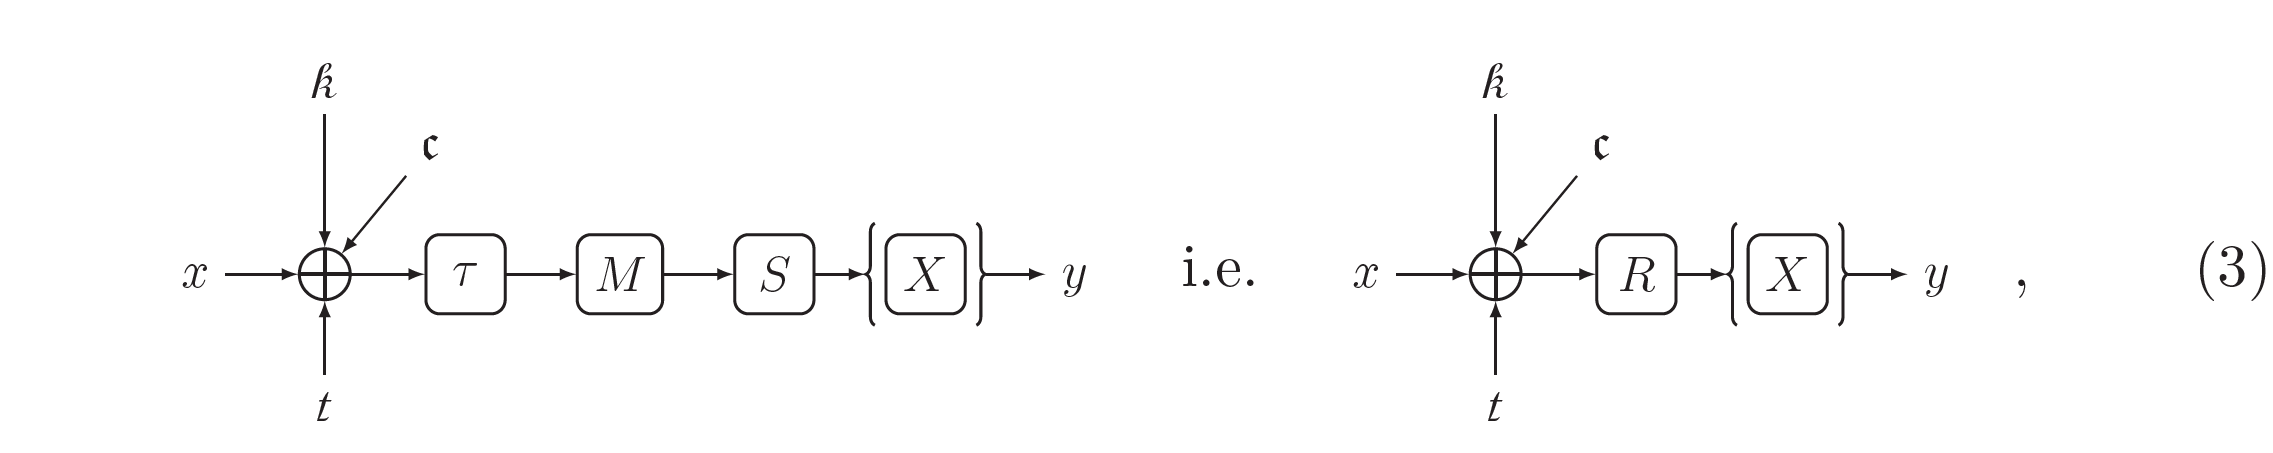

In [ ]:
tau = [0, 11, 6, 13, 10, 1, 12, 7, 5, 14, 3, 8, 15, 4, 9, 2]


def permutation(state: list, p: list) -> list:
    return [state[p[i]] for i in range(len(state))]

